In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

Load Dataset

In [2]:
df = pd.read_csv('data/energy_weather_raw_data.csv')

Data Inspection

In [3]:
print(df.head())

                  date  active_power  current  voltage  reactive_power  \
0  2022-11-05 14:05:00         265.1     2.53    122.2          159.09   
1  2022-11-05 14:06:00         265.1     2.53    122.2          159.09   
2  2022-11-05 14:07:00         265.1     2.53    122.2          159.09   
3  2022-11-05 14:08:00         640.0     5.45    120.7          152.08   
4  2022-11-05 14:09:00         257.6     2.47    122.4          158.26   

   apparent_power  power_factor   main description   temp  feels_like  \
0          309.17        0.8575  Clear   clear sky  24.19       23.68   
1          309.17        0.8575  Clear   clear sky  24.19       23.68   
2          309.17        0.8575  Clear   clear sky  24.19       23.68   
3          657.82        0.9729  Clear   clear sky  24.19       23.68   
4          302.33        0.8520  Clear   clear sky  24.19       23.68   

   temp_min  temp_max  pressure  humidity  speed  deg  temp_t+1  \
0     23.44      27.5      1013        39    0.0 

In [4]:
print(df.shape)

(605260, 19)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605260 entries, 0 to 605259
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            605260 non-null  object 
 1   active_power    605260 non-null  float64
 2   current         605260 non-null  float64
 3   voltage         605260 non-null  float64
 4   reactive_power  605260 non-null  float64
 5   apparent_power  605260 non-null  float64
 6   power_factor    605260 non-null  float64
 7   main            605260 non-null  object 
 8   description     605260 non-null  object 
 9   temp            605260 non-null  float64
 10  feels_like      605260 non-null  float64
 11  temp_min        605260 non-null  float64
 12  temp_max        605260 non-null  float64
 13  pressure        605260 non-null  int64  
 14  humidity        605260 non-null  int64  
 15  speed           605260 non-null  float64
 16  deg             605260 non-null  int64  
 17  temp_t+1  

In [6]:
print(df.describe())

        active_power        current        voltage  reactive_power  \
count  605260.000000  605260.000000  605260.000000   605260.000000   
mean      286.019377       2.587303     125.417300      132.538007   
std       189.545683       1.591395       4.390612       71.030254   
min        24.400000       0.300000     107.600000        4.730000   
25%       159.800000       1.610000     122.600000       74.070000   
50%       250.300000       2.290000     124.400000      128.500000   
75%       365.400000       3.220000     129.500000      177.652500   
max      2900.000000      24.410000     135.500000     1293.580000   

       apparent_power   power_factor           temp     feels_like  \
count   605260.000000  605260.000000  605260.000000  605260.000000   
mean       321.839271       0.854202      19.525256      18.712625   
std        191.743962       0.114629       6.607351       6.722516   
min         37.140000       0.201800      -5.560000      -6.130000   
25%        203.5800

In [7]:
print(df.isnull().sum()) # Check for missing values

date              0
active_power      0
current           0
voltage           0
reactive_power    0
apparent_power    0
power_factor      0
main              0
description       0
temp              0
feels_like        0
temp_min          0
temp_max          0
pressure          0
humidity          0
speed             0
deg               0
temp_t+1          0
feels_like_t+1    0
dtype: int64


In [8]:
print(df.duplicated().sum()) # Check for duplicate rows

2


In [9]:
# remove duplicates
df.drop_duplicates(inplace=True)

In [10]:
# print df shape after removing duplicates
print(f"Data shape after removing duplicates: {df.shape}")

Data shape after removing duplicates: (605258, 19)


Date Handling

In [11]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

Feature Engineering

In [12]:
for i in range(1, 4):  # Create lag features up to 3 time steps
    df[f'active_power_lag_{i}'] = df['active_power'].shift(i)

In [13]:
df['active_power_rolling_mean'] = df['active_power'].rolling(window=10).mean()
df['active_power_rolling_std'] = df['active_power'].rolling(window=10).std()

In [14]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year

In [15]:
df['temp_humidity_interaction'] = df['temp'] * df['humidity']

In [16]:
# Drop rows with missing values
df.dropna(inplace=True)
print(df.isnull().sum()) # Check for missing values again

active_power                 0
current                      0
voltage                      0
reactive_power               0
apparent_power               0
power_factor                 0
main                         0
description                  0
temp                         0
feels_like                   0
temp_min                     0
temp_max                     0
pressure                     0
humidity                     0
speed                        0
deg                          0
temp_t+1                     0
feels_like_t+1               0
active_power_lag_1           0
active_power_lag_2           0
active_power_lag_3           0
active_power_rolling_mean    0
active_power_rolling_std     0
hour                         0
day                          0
month                        0
year                         0
temp_humidity_interaction    0
dtype: int64


Scaling

In [17]:
# Convert categorical variables to numerical
numerical_cols = ['active_power', 'current', 'voltage', 'reactive_power', 'apparent_power',
                    'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed',
                    'temp_t+1','feels_like_t+1'] # Add any newly engineered numerical columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [18]:
# Convert categorical columns to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['main', 'description'], drop_first=True)

Exploratory Data Analysis (EDA)

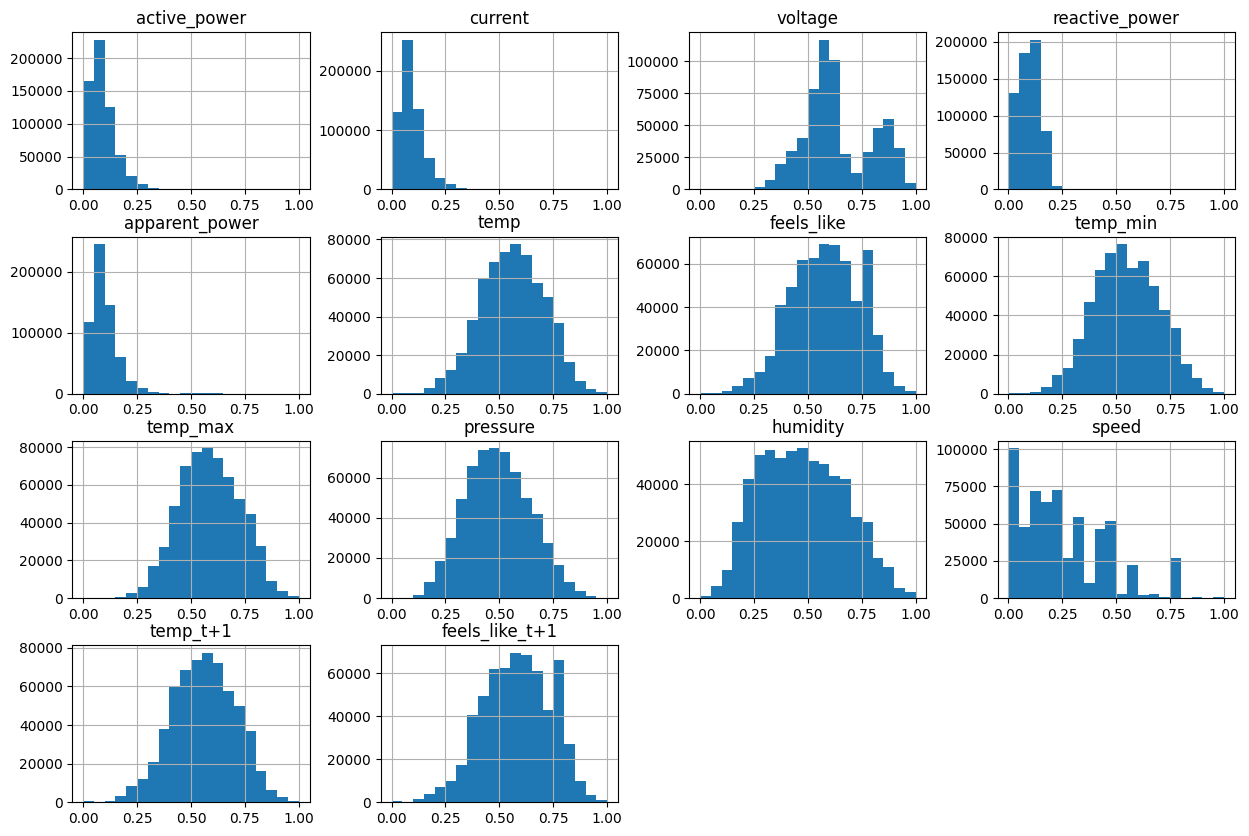

In [19]:
# Univariate analysis
df[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.show()

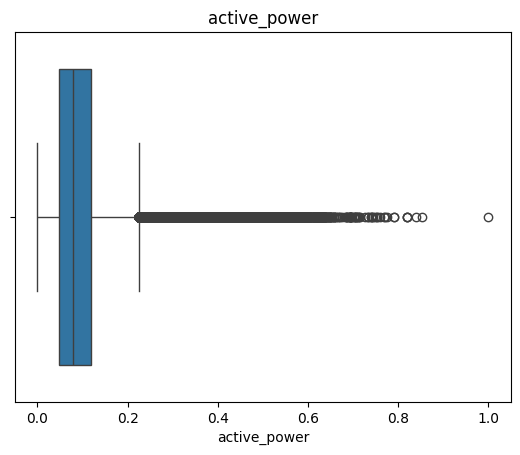

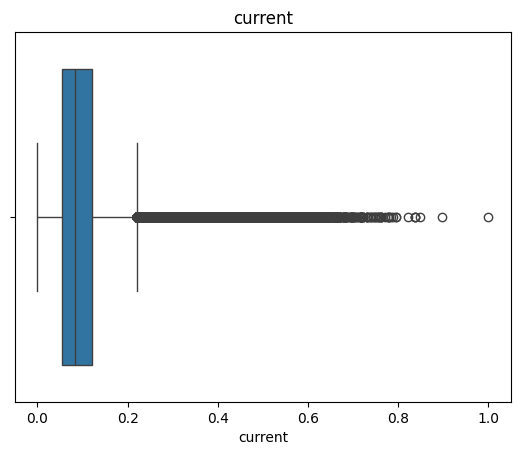

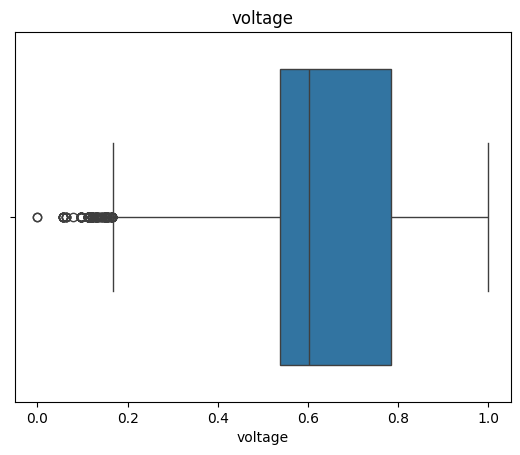

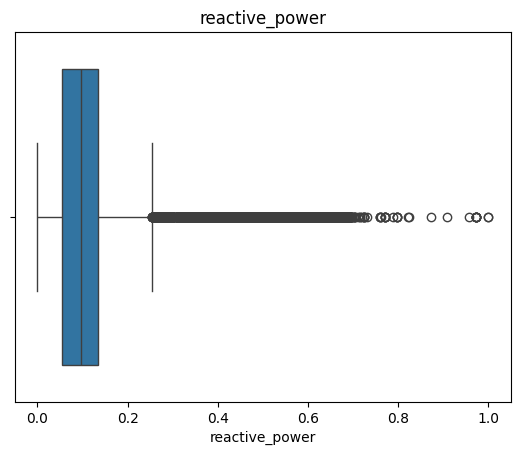

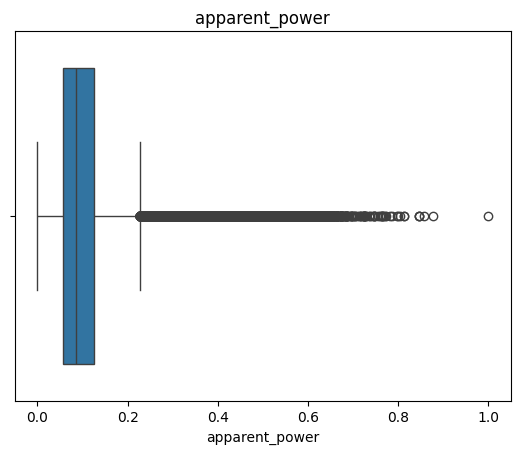

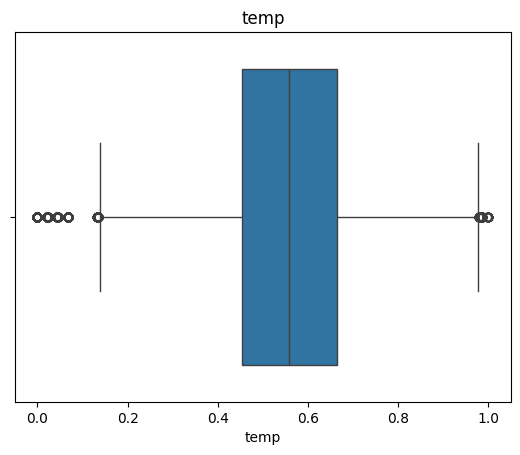

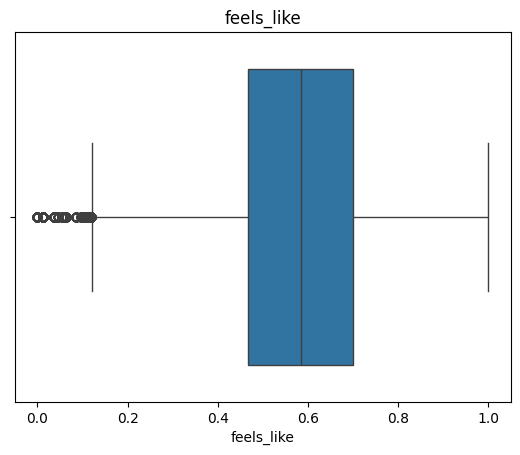

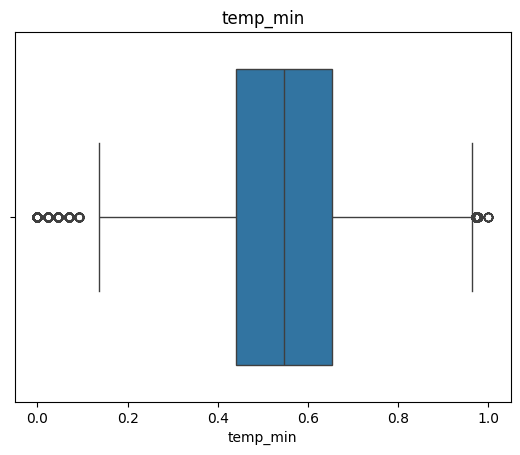

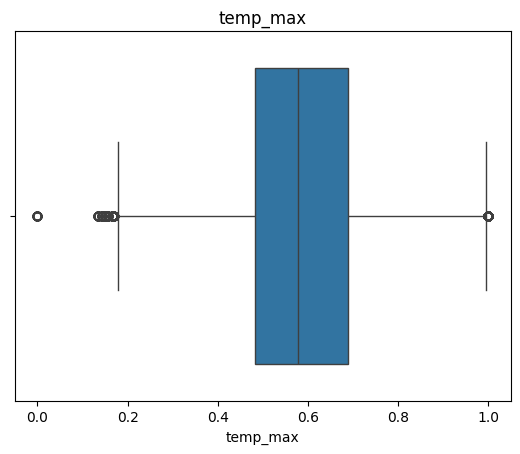

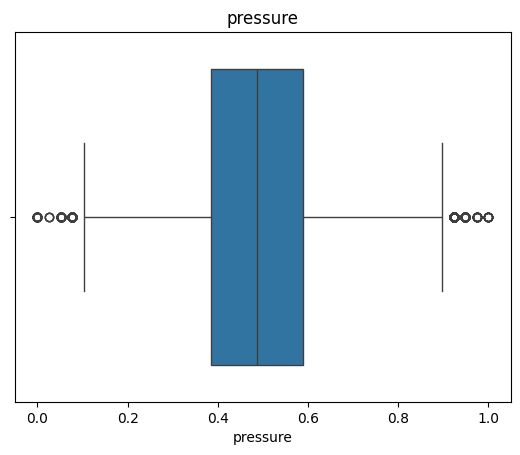

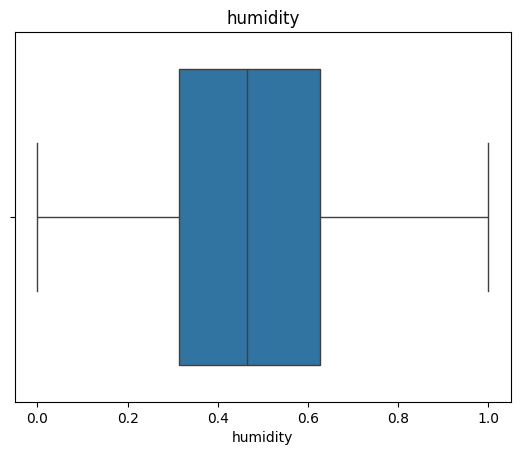

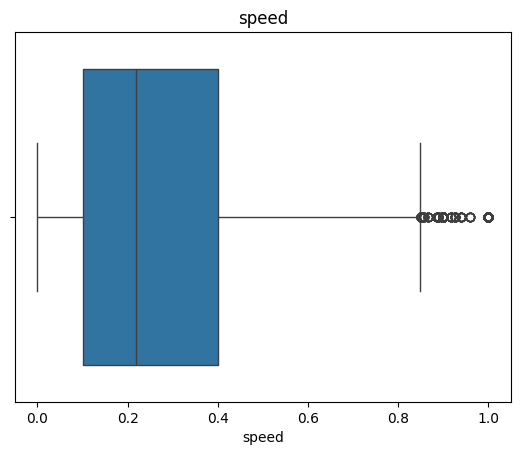

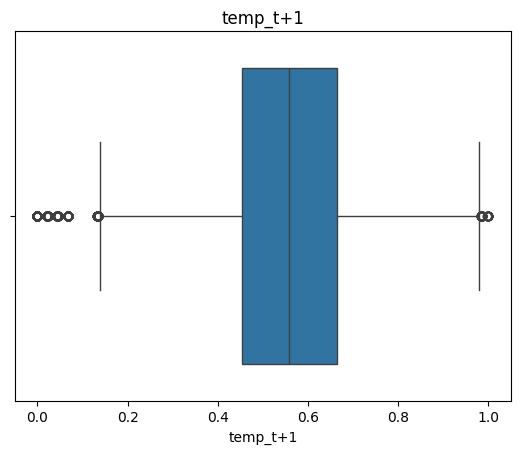

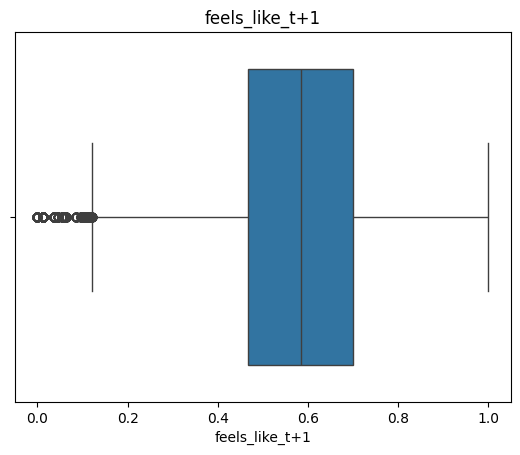

In [20]:
# Identify outliers
for col in numerical_cols:
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

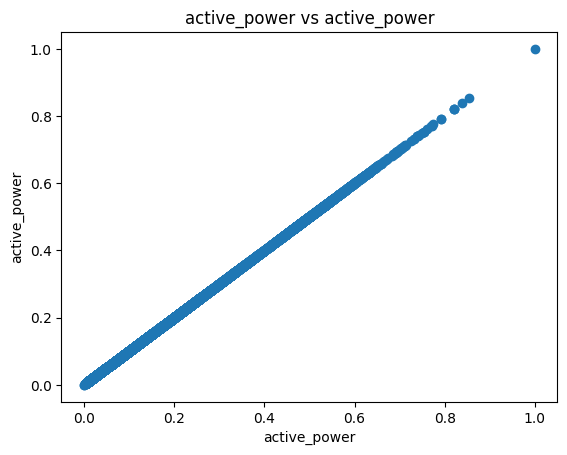

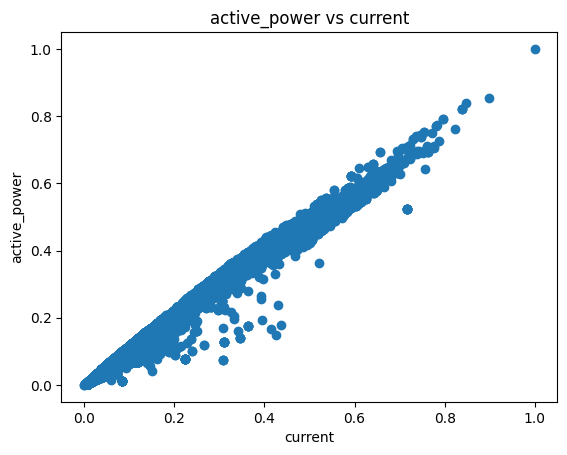

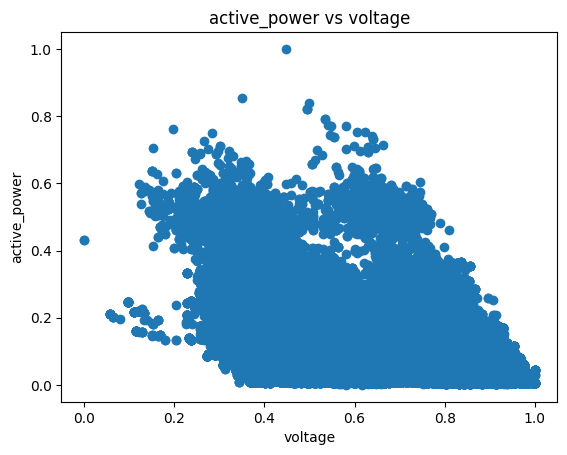

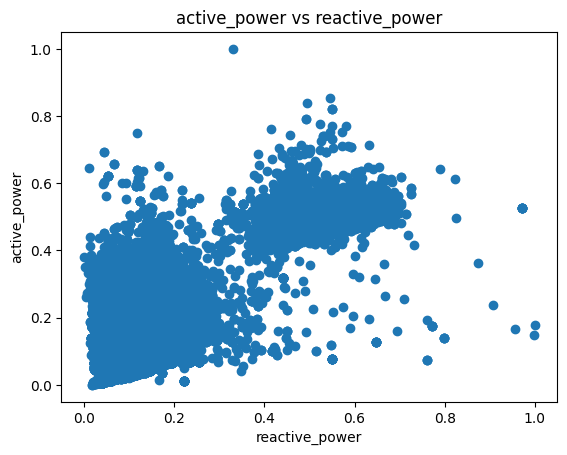

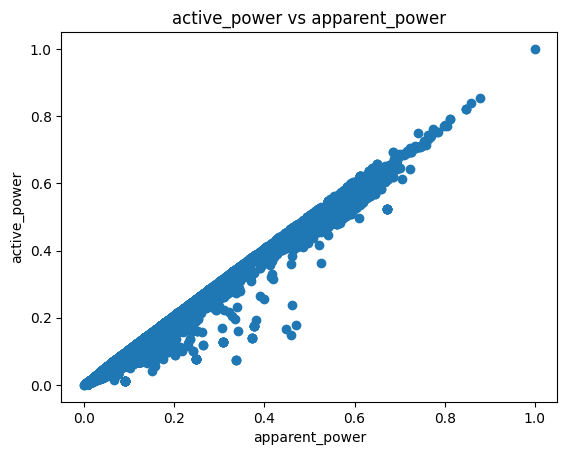

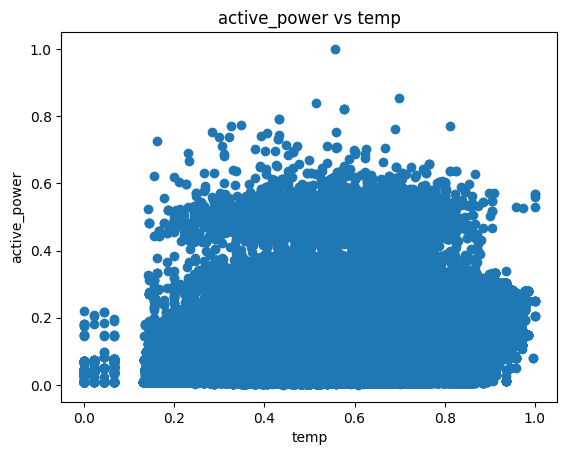

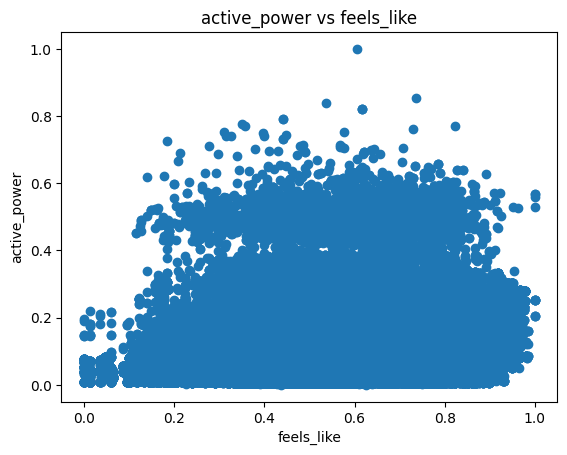

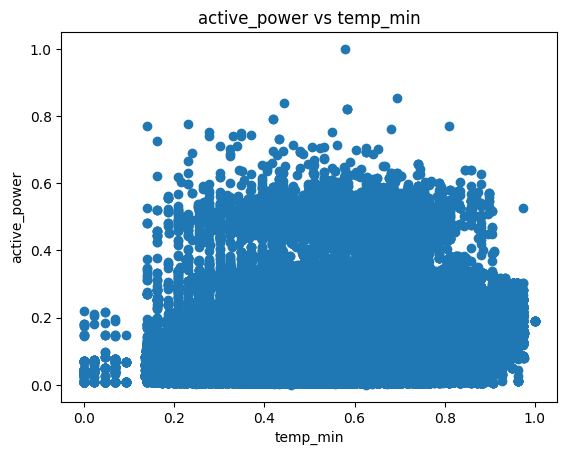

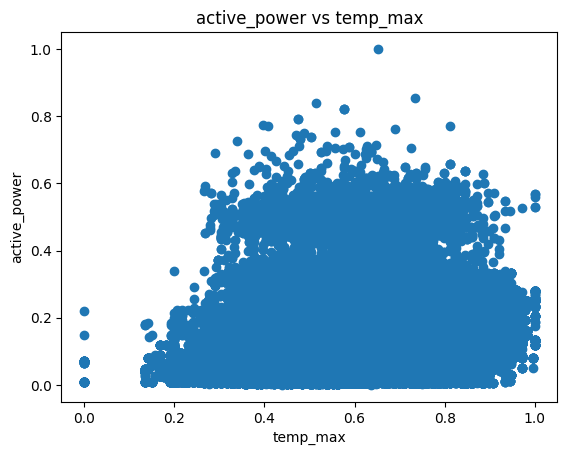

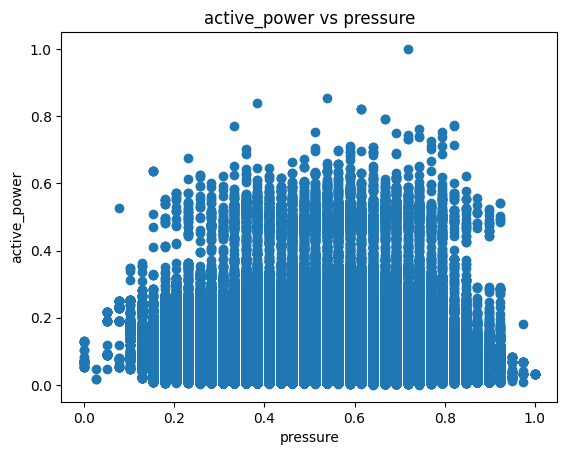

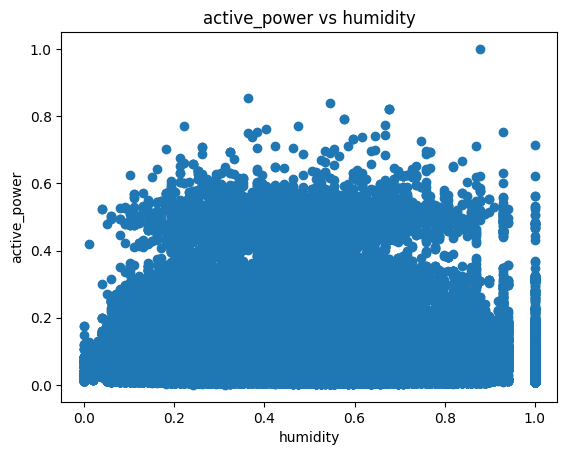

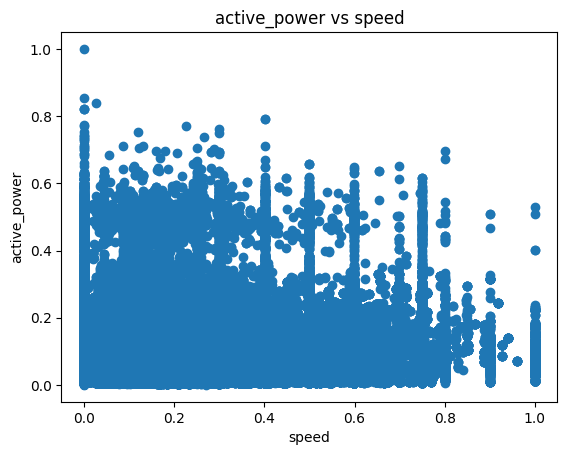

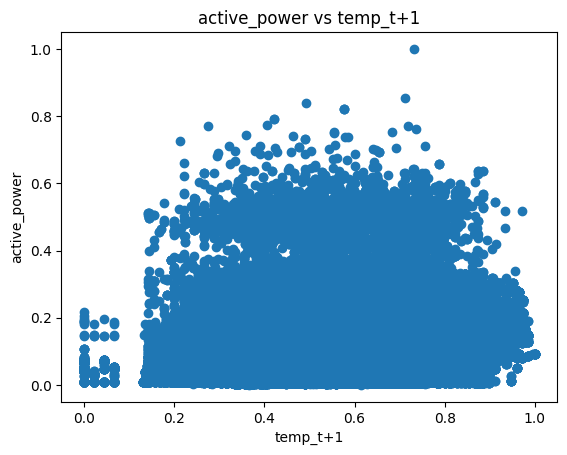

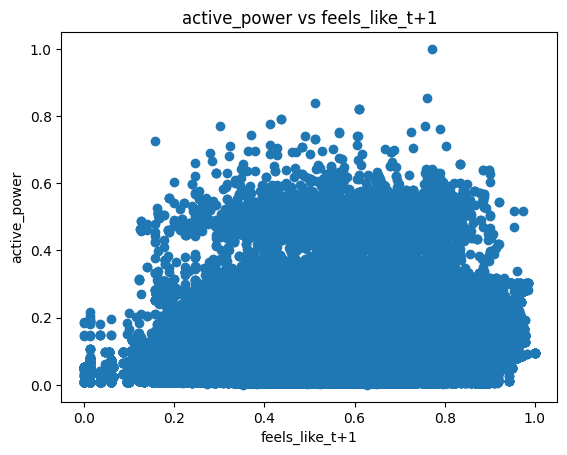

In [21]:
# Bivariate analysis
for col in numerical_cols:
    plt.scatter(df[col], df['active_power'])
    plt.xlabel(col)
    plt.ylabel('active_power')
    plt.title(f'active_power vs {col}')
    plt.show()

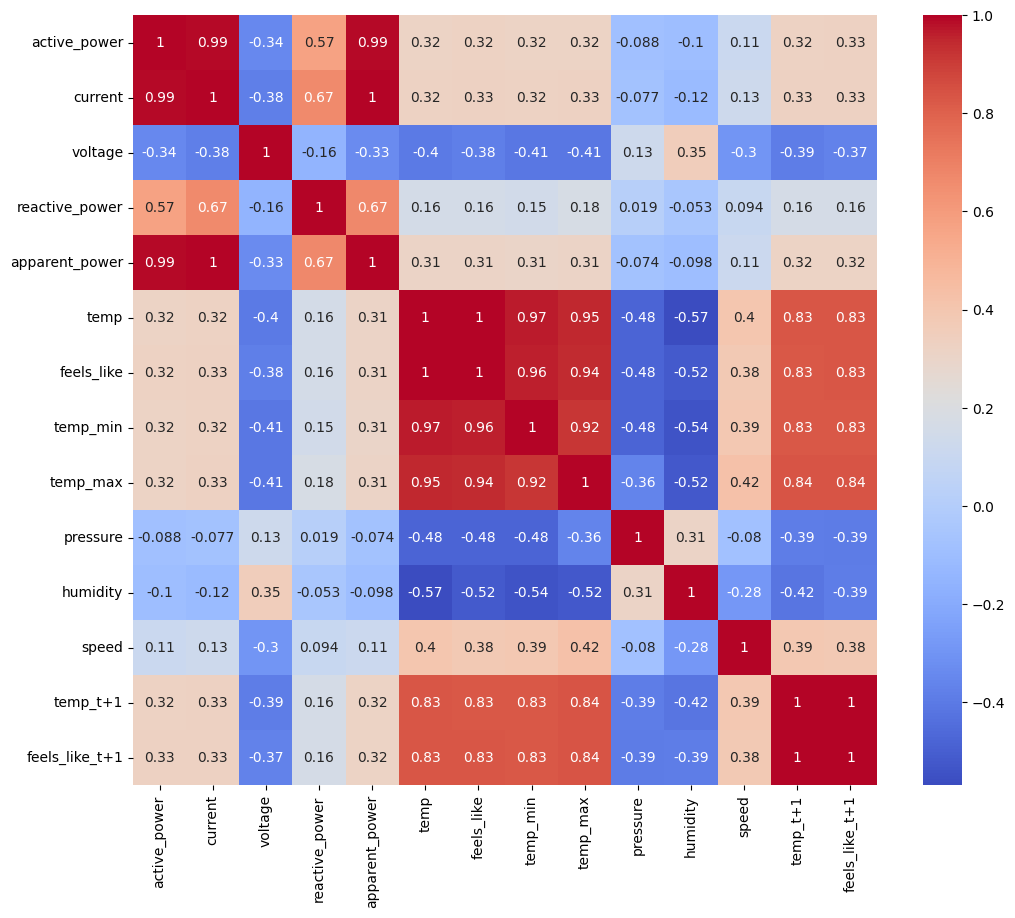

In [22]:
# Correlation matrix
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

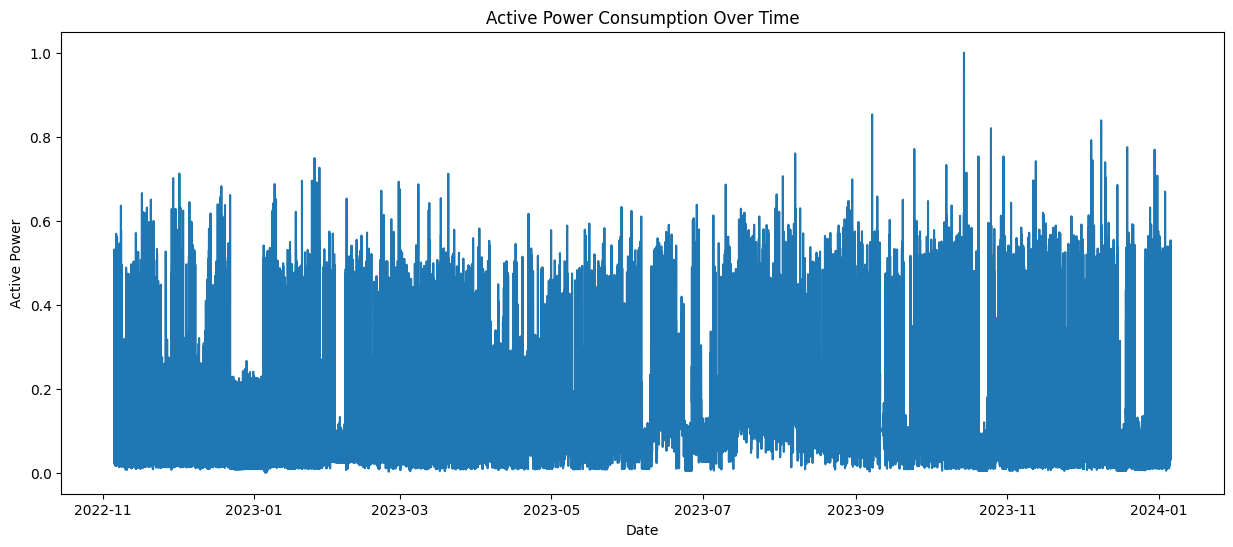

In [23]:
# Time series analysis
plt.figure(figsize=(15, 6))
plt.plot(df['active_power'])
plt.title('Active Power Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Active Power')
plt.show()

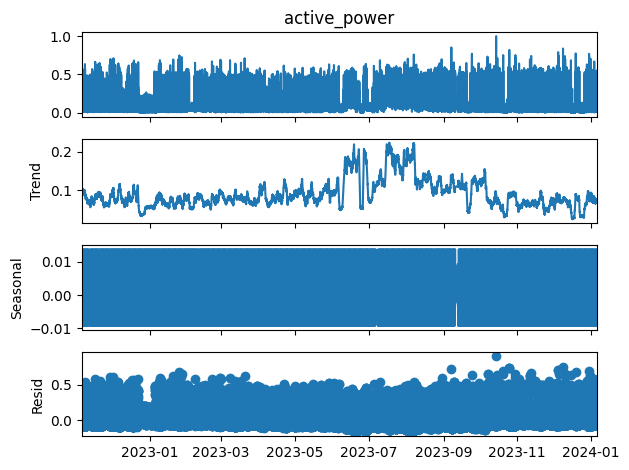

In [24]:
# Seasonal decomposition
decomposition = seasonal_decompose(df['active_power'], model='additive', period=24*60) #assuming 1 day period in minutes
decomposition.plot()
plt.show()

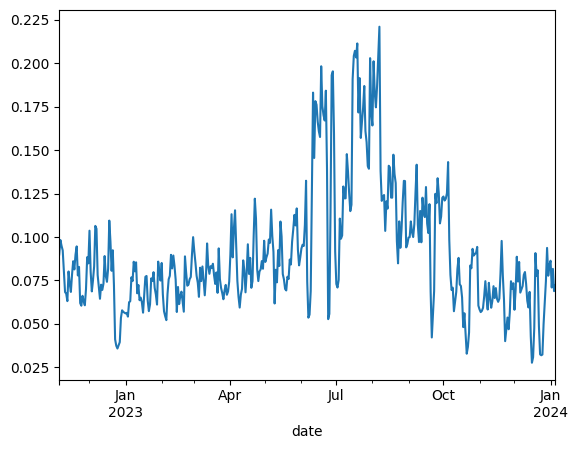

/var/folders/rx/gyp8p3vs42zfzk_hwhrnpcmw0000gn/T/ipykernel_29076/231123692.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['active_power'].resample('M').mean().plot() #monthly mean


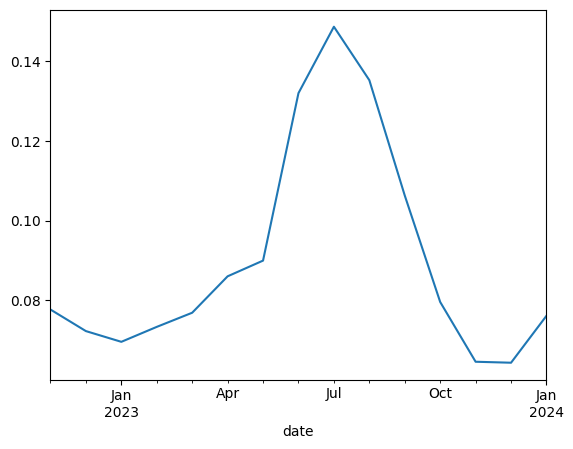

In [25]:
# Autocorrelation and Partial Autocorrelation
df['active_power'].resample('D').mean().plot() #daily mean
plt.show()
df['active_power'].resample('M').mean().plot() #monthly mean
plt.show()

In [26]:
# Save the cleaned and preprocessed data
df.to_csv('data/energy_weather_preprocessed.csv', index=False)